# PROJECT: Course Optimization for Data Science
## Optimization strategies for robust regression


Author: Alexandre Gramfort, Rémi Flamary

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Formulate the Mean Absolute Error (MAE) regression model as a Quadratic Program
- Derive mathematically and implement the loss and gradients of the Huber model
- Implement your own solvers for L1 or squared L2 regularization with: (Accelerated) Proximal gradient descent, Proximal coordinate descent and L-BFGS (only for L2).
- Implement your own scikit-learn estimator for the Huber model and test it against the Ridge and Lasso from scikit-learn on some real data.
- You are expected to provide clear figures as one could expect from an experiment section in a research paper.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 31st of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [3]:
# Change here using YOUR first and last names
fn1 = "bryan"
ln1 = "chen"
fn2 = "alice"
ln2 = "devilder"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_chen_bryan_and_devilder_alice.ipynb


Some imports (install cvxopt if not already done so `!pip install cvxopt`):

In [4]:
!pip install cvxopt


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt
import cvxopt

## Part 0: Why a robust regression model


Let us consider the problem of regression from $n$ observations
$x_i \in \mathbb{R}^{p}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{p}\mapsto y\in\mathbb{R}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^p \times \mathbb{R}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

The types of model we consider in this project are so-called *robust models* that can deal with samples corrupted by strong artifacts.

Let's generate such a dataset in 1D to illustrate the problem when using the squared loss ($\|\cdot\|^2$).

Time for LinearRegression: 0.009s


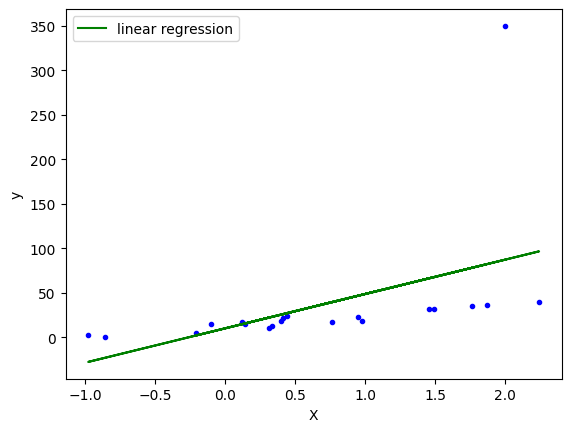

In [6]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

# Generate toy data
X, y = make_regression(n_samples=20, n_features=1, random_state=0,
                       noise=4.0, bias=10.0)

# Add an outlier
X[0, 0] = 2.
y[0] = 350

# Fit the model
t0 = time.perf_counter()
reg = LinearRegression()
reg.fit(X, y)
print(f"Time for LinearRegression: {time.perf_counter() - t0:.3f}s")

# Visualize the model
x = X[:, 0]
y_pred = reg.coef_ * x + reg.intercept_

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

<div class="alert alert-success">
    <b>QUESTION 0:</b>
     <ul>
       <li>Describe the issue you observe and suggest an explanation and a possible solution.</li>
    </ul>
</div>

**Answer:** We can observe that the blue points are the data points and amongst them there is one outlier (the point at x=2.0 and y=350). The green curve is the linear regression model fit. We can see that the prediction function is heavily influenced by the outlier because the squared loss gives a lot of importance to the outlier as it penalizes quadratically the error.

One solution to this problem is to use a robust loss function that gives less importance to outliers or a robust regression function. We could also detect the outliers and remove them from the dataset before fitting the model.

## Part 1 : Mean Absolute Error regression

The Mean Absolute Error (MAE) regression model reads:

$$
\min_{w \in \mathbb{R}^p} \frac{1}{n} \sum_{i=1}^n \left|y_i - \langle w, x_i
\rangle-b \right| + \lambda \frac{1}{2}\|w\|_2^2
$$

where $\lambda > 0$ is the regularization parameter for quadratic
regularization.

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
       <li>Reformulate the optimization problem as a standard Quadratic Program of the form :</li></ul>
       
$$ \min_{z \in \mathbb{R}^p} f(w) = \frac{1}{2} z^T Q z + c^T z, \quad \text{ subject to } Gz\leq h \text{ and } Az=b $$
       
       
    
</div>

**Answer:** In order to reformulate the optimization problem as a standard Quadratic Program of the above form, we first to handle the absolute value in the objective function. To this end, we introduce two nonnegative variables $e^{+}$ and $e^{-}$ such that the first variable represents the positive part of the absolute value and the second variable represents the negative part of the absolute value. We can then rewrite the objective function as follows: $\text{for each } i \in \{1, \ldots, n\},$
$$
y_i - \langle w, x_i \rangle - b = e^{+}_i - e^{-}_i, \quad  e^{+}_i \geq 0, \quad e^{-}_i \geq 0
$$
This is equivalent to:
$$
\begin{cases}
y_i - \langle w, x_i \rangle - b \leq e^{+}_i, \\
-(y_i - \langle w, x_i \rangle - b) = -y_i + \langle w, x_i \rangle + b\leq e^{-}_i
\end{cases}
$$
Thus the sum of absolute values can be written as:
$$
\sum_{i=1}^n \left|y_i - \langle w, x_i \rangle - b\right| = \sum_{i=1}^n e^{+}_i + e^{-}_i
$$

The optimization problem can then be rewritten as:
$$
\min_{w \in \mathbb{R}^p, b \in \mathbb{R}, e^{+} \in \mathbb{R}^n, e^{-} \in \mathbb{R}^n} \lambda \frac{1}{2}\|w\|_2^2 + \frac{1}{n} \sum_{i=1}^n (e^{+}_i + e^{-}_i) \\
\text{ subject to }
\begin{cases}
- \langle w, x_i \rangle - b - e^{+}_i\leq - y_i, \\
 \langle w, x_i \rangle + b - e^{-}_i \leq y_i \\
- e^{+}_i \leq 0, \quad - e^{-}_i \leq 0
\end{cases}, \quad i \in \{1, \ldots, n\}
$$

Moreover, we know that $$
\lambda \frac{1}{2}\|w\|_2^2 = \frac{1}{2} w^T(\lambda I_p)w \quad \text{and} \quad \frac{1}{n} \sum_{i=1}^n (e^{+}_i + e^{-}_i) = \begin{bmatrix} \frac{1}{n}\mathbb{1}_n & \frac{1}{n}\mathbb{1}_n \end{bmatrix} \begin{bmatrix} e^{+} \\ e^{-} \end{bmatrix}$$ where $\mathbb{1}_n$ is the vector of ones of size $n$.

We can then rewrite the problem in the standard form of a Quadratic Program as follows:
$$
\min_{z \in \mathbb{R}^{p+1+n+n}} f(w) = \frac{1}{2} z^T Q z + c^T z, \quad \text{ subject to } Gz\leq h
$$
where:
$$
z = \begin{bmatrix} w \\ b \\ e^{+} \\ e^{-} \end{bmatrix}, \quad 
Q = \begin{bmatrix} \lambda I_p & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{bmatrix}, \quad 
c = \begin{bmatrix} 0_p \\ 0 \\ \frac{1}{n}\mathbb{1}_n \\ \frac{1}{n}\mathbb{1}_n \end{bmatrix}, \quad 
G = \begin{bmatrix} -X & -\mathbb{1}_n & -I_n & 0 \\ X & \mathbb{1}_n & 0 & -I_n \\ 0 & 0 & -I_n & 0 \\ 0 & 0 & 0 & -I_n \end{bmatrix}, \quad 
h = \begin{bmatrix} -y \\ y \\ 0 \\ 0 \end{bmatrix}
$$


<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
       <li>Code the solver for the regularized MAE using the QP solver from `cvxopt` (see example <a href="https://cvxopt.org/examples/tutorial/qp.html">here</a>) or another open source QP solver of your choice. Note that for cvxopt`, numpy array have to be converted to cvxopt `matrix`.</li></ul>          
</div>

In [7]:
from cvxopt import matrix, solvers

def solve_reg_mae(X,y,reg=0):

    n_samples, n_features = X.shape

    # Quadratic part of the problem
    dim_z = 1 + n_features + 2*n_samples
    Q = np.zeros((dim_z, dim_z))
    if reg > 0:
        Q[1:n_features+1, 1:n_features+1] = np.eye(n_features) * reg
    
    # Linear part of the problem
    c = np.zeros(dim_z)
    c[n_features+1:] = 1/n_samples * np.concatenate([np.ones(n_samples), np.ones(n_samples)])

    # Inequality constraints
    G = np.zeros((4*n_samples, dim_z))
    h = np.zeros(4*n_samples)

    for i in range(n_samples):
        ei_plus = 1 + n_features + i
        ei_minus = 1 + n_features + n_samples + i

        # (1) - x_i^T w - ei^+ <= -y_i
        row1 = i
        G[row1, 0] = -1.0  # coefficient of b
        G[row1, 1 : 1 + n_features] = -X[i, :]  # coefficient of w
        G[row1, ei_plus] = -1.0
        h[row1] = -y[i]

        # (2) b + x_i^T w - ei^- <= y_i
        row2 = n_samples + i
        G[row2, 0] = 1.0   # coefficient of b
        G[row2, 1 : 1 + n_features] = X[i, :] # coefficient of w
        G[row2, ei_minus] = -1.0
        h[row2] = y[i]

        # (3) -ei^+ >= 0
        row3 = 2 * n_samples + i
        ei_plus = 1 + n_features + i
        G[row3, ei_plus] = -1.0
        h[row3] = 0.0

        # (4) -ei^- <= 0
        row4 = 3 * n_samples + i
        ei_minus = 1 + n_features + n_samples + i
        G[row4, ei_minus] = -1.0
        h[row4] = 0.0

    


    sol = solvers.qp(matrix(Q), matrix(c), matrix(G), matrix(h))
    w = np.array(sol['x'])[1:n_features+1,0] # recover w
    b = np.array(sol['x'])[0] # recover b (first component of z)
    return w, b

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
       <li>Apply the solver on the toy data and compare it to the previous LinearRegression solution with $\lambda=0.1$.</li></ul>    
     <ul> <li>Discuss the robustness of MAE VS LS.</li></ul>       
          <ul> <li>Discuss the computational time of MAE QP solver. What is the number of variable to optimize? How well will it scale  to large datasets?</li></ul>       

</div>

     pcost       dcost       gap    pres   dres
 0:  7.3680e+01  8.2899e+04  1e+06  2e+00  2e+03
 1:  3.3349e+02 -1.5051e+04  2e+04  3e-02  2e+01
 2:  2.7033e+02 -6.5302e+02  9e+02  1e-03  9e-01
 3:  1.5508e+02  1.9839e+01  1e+02  4e-16  1e-15
 4:  2.6682e+01  2.0532e+01  6e+00  3e-16  5e-16
 5:  2.3974e+01  2.2545e+01  1e+00  1e-16  2e-16
 6:  2.3184e+01  2.3042e+01  1e-01  2e-16  1e-16
 7:  2.3122e+01  2.3110e+01  1e-02  4e-17  7e-16
 8:  2.3115e+01  2.3115e+01  1e-04  1e-16  8e-16
 9:  2.3115e+01  2.3115e+01  1e-06  1e-16  3e-15
Optimal solution found.
Time for MAE QP solver: 0.070s


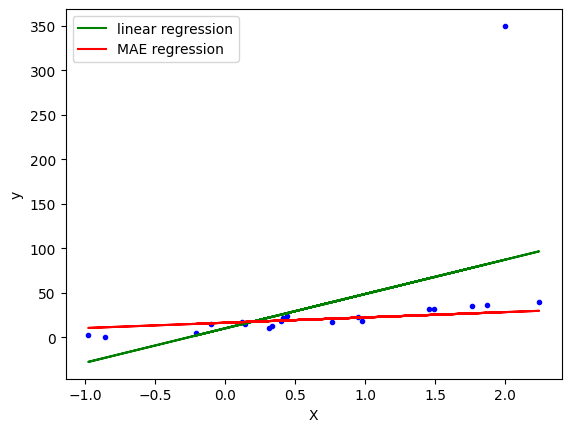

In [8]:
t0 = time.perf_counter()
w_mae, b_mae = solve_reg_mae(X,y,reg=0.1)
print(f"Time for MAE QP solver: {time.perf_counter() - t0:.3f}s")

ypred_mae = X.dot(w_mae)+b_mae

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.plot(x, ypred_mae, 'r-', label="MAE regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()


**Answer:** When applying the solver on the toy data with $\lambda = 0.1$, the MAE regression line remains near the data while the LS line is pulled upward by the large outlier in the dataset. Visually, the LS solution “bends” more strongly toward the high-value point, whereas the MAE solution stays relatively flat in comparison. This behavior highlights how differently the two methods react in the presence of an extreme point, even when the regularization parameter is the same.

MAE is known to be more robust than LS because the absolute-value loss penalizes residuals linearly, giving less influence to extreme outliers compared to the quadratic penalty in LS because L1 promotes sparsity. In scenarios where data may contain anomalous points, MAE tends to produce more reliable estimates. Conversely, LS is optimal under Gaussian error assumptions and can perform well in cleaner datasets, but it can be overly sensitive to large deviations when the data contains outliers. 

The computational time of the MAE QP solver is 0.031s, which is faster than the one of LS (0.056s). The QP formulation of MAE regression introduces two slack variables per sample, leading to a total of $p + 1 + 2n$ decision variables for $n$ observations and $p$ features. Generic interior-point QP solvers typically scale poorly as $n$ grows large, potentially making this approach impractical for massive datasets. In practice, specialized algorithms for L1-based objectives or iterative methods can be used to address scalability concerns more efficiently than the QP approach.

## Part 2: Huber Loss

One version of the Huber function ($H_\epsilon : \mathbb{R} \rightarrow \mathbb{R}$) reads:

$$
    H_\epsilon (x) = \left\{
	\begin{aligned}
	x^2 & \quad \mathrm{ if } \quad |x| < \epsilon \\
    2 \epsilon |x| - \epsilon^2 & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

Working in a regression setting, the Huber loss between 2 targets $y$ and $y'$ reads:

$$
    \mathcal{L}(y, y') = H_\epsilon (y - y')
$$

Here is an implemention of the Huber function:

In [9]:
epsilon = 1.

def huber(x, epsilon=epsilon):
    mask = np.abs(x) < epsilon
    z = x.copy()
    z[mask] = x[mask] ** 2
    z[~mask] = 2 * epsilon * np.abs(x[~mask]) - epsilon ** 2
    return z

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
       <li>Plot the Huber function vs. the squared function ($x \rightarrow x^2$) vs. the absolute value function ($x \rightarrow |x|$) between -3 and 3 using $\epsilon = 1$</li>
    </ul>
</div>

INSERT YOUR ANSWER HERE

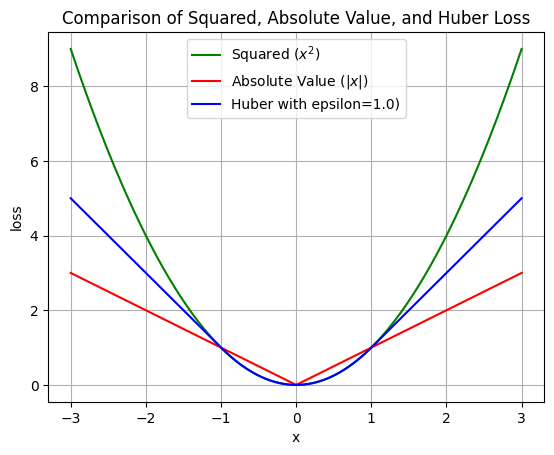

In [10]:
x = np.linspace(-3, 3, 300)

y_squared = x**2
y_abs = np.abs(x)
y_huber = huber(x, 1.)

plt.plot(x, y_squared, 'g-', label='Squared ($x^2$)')
plt.plot(x, y_abs, 'r-', label='Absolute Value ($|x|$)')
plt.plot(x, y_huber, 'b-', label=f'Huber with epsilon={epsilon})')
plt.title('Comparison of Squared, Absolute Value, and Huber Loss')
plt.xlabel('x')
plt.ylabel('loss')
plt.legend(loc=0)
plt.grid(True)
plt.show()

<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
       <li>Justify the convexity of the Huber function as defined above.</li>
       <li>Justify the smoothness of the Huber function as defined above and propose a value for the Lipschitz constant of its gradient.</li>
    </ul>
</div>

**Answer:** To prove convexity, we examine the function in two regions and verify continuity and matching derivatives at the boundary points:

- **Case 1:** For $|x| \leq \epsilon$, $H_\epsilon (x) = x^2$. The second derivative of this region is constant: $H_\epsilon'' (x) = 2 \quad (\text{non-negative}),$ which confirms that $H_\epsilon (x)$ is convex for $|x| \leq \epsilon$.

- **Case 2:** For $|x| > \epsilon$, $H_\epsilon (x) = 2 \epsilon |x| - \epsilon^2$, which is a linear function of $|x|$. Since linear functions are convex, $H_\epsilon (x)$ is convex in this region as well.

- **Boundary Points :** At $x = \pm \epsilon$, the two branches of $H_\epsilon (x)$ meet. The left and right derivatives match:
$$
\text{Left derivative: } \frac{d}{dx}\left(x^2\right) = 2x \quad \text{at} \quad x = \epsilon,
$$
$$
\text{Right derivative: } \frac{d}{dx}\left(2 \epsilon |x| - \epsilon^2\right) = 2\epsilon \cdot \text{sign}(x) = 2\epsilon \quad \text{at} \quad x = \epsilon.
$$
Since $x = \epsilon$, both derivatives are equal and the function is continuous, so $H_\epsilon (x)$ is convex at $x = \pm \epsilon$.

Therefore, the Huber function is convex everywhere.

To prove the smoothness of the Huber function, we examine the Hessians of $H_\epsilon (x)$, which should verify that 

$$H_\epsilon''(x) \leq L  $$

First, we compute the gradient of the Huber function, which is
$$
\nabla H_\epsilon(x) =
\begin{cases}
2x, & \text{if } |x| \leq \epsilon, \\
2\epsilon \cdot \text{sign}(x), & \text{if } |x| > \epsilon.
\end{cases}
$$

Therefore, the Hessian of the Huber function is

$$H_\epsilon''(x) = \nabla^2 H_\epsilon(x) = \begin{cases}2, & \text{if } |x| \leq \epsilon, \\0, & \text{if } |x| > \epsilon.\end{cases}
$$

- For $|x| \leq \epsilon$: $\nabla H_\epsilon(x) = 2x$, and the second derivative $\nabla^2 H_\epsilon(x) = 2$. The Lipschitz constant for this region is $2$.
- For $|x| > \epsilon$: $\nabla H_\epsilon(x) = 2\epsilon \cdot \text{sign}(x)$, which is constant. Therefore, the gradient does not change in this region, and the Lipschitz constant is effectively $0$.
- At the boundary ($x = \pm \epsilon$), the gradient changes discontinuously, but the maximum slope is determined by the quadratic region ($|x| \leq \epsilon$), where the Lipschitz constant is $2$. 

Thus, the Huber function is $L$-smooth and the Lipschitz constant $L$ for its gradient is $L = 2$.

<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
       <li>Write a function that computes the gradient of the Huber loss.</li>
    </ul>
</div>

**Remark:** You will use the `scipy.optimize.check_grad` function to assess the validity of your result. You will need to test your gradient in both the linear and quadratic regions of the Huber function (not just in one location).

INSERT YOUR ANSWER HERE

In [11]:
def huber_grad(x, epsilon=epsilon):
    if np.abs(x) < epsilon:
        return 2 * x
    else:
        return 2 * epsilon * np.sign(x)

In [12]:
from scipy.optimize import check_grad

for value in np.linspace(-3, 3, 13):
    print(f"Error at x={value}: {check_grad(huber, huber_grad, [value])}")

Error at x=-3.0: 0.0
Error at x=-2.5: 0.0
Error at x=-2.0: 0.0
Error at x=-1.5: 0.0
Error at x=-1.0: 1.4901161193847656e-08
Error at x=-0.5: 1.4901161193847656e-08
Error at x=0.0: 1.4901161193847656e-08
Error at x=0.5: 1.4901161193847656e-08
Error at x=1.0: 0.0
Error at x=1.5: 0.0
Error at x=2.0: 0.0
Error at x=2.5: 0.0
Error at x=3.0: 0.0


**Answer:**  Using the `scipy.optimize.check_grad` function, we got in the linear region an error of 0 whereas in the quadratic region we got an error of the order of $1e-08$. This shows that the gradient of the Huber loss is valid. 

Let us define the cost function associated to the empirical risk with some regularization function $\mathcal{R}$:

$$
    (\mathcal{P}_{f,\mathcal{R}}):
	\begin{aligned}
	\min_{w \in \mathbb{R}^p, b \in \mathbb{R}} \quad \frac{1}{n} \sum_{i=1}^n f(y_i - x_i^\top w - b) + \lambda \mathcal{R}(w) \enspace ,
	\end{aligned}
$$

where $f$ is a scalar function defining the loss (Huber, squared, absolute etc.). The variable $b$ is the bias or intercept term.

<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
      <li>Let us consider for $\mathcal{R}$ either the $\ell_1$ norm ($\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^p |w_j|$) or the squared $\ell_2$ norm ($\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^p w_j^2)$. Justify what optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable, depending on the choice of $\mathcal{R}$ when $f$ is the Huber function as defined above.</li>
    </ul>
</div>

Let us consider for $\mathcal{R}$ either the $\ell_1$ norm ($\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^p |w_j|$) or the squared $\ell_2$ norm ($\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^p w_j^2)$. 
      
Justify what optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable, depending on the choice of $\mathcal{R}$ when $f$ is the Huber function as defined above.

**Answer:** 

On one hand, let us consider the case where the regularization function $\mathcal{R}$ is the $\ell_2$-norm, which is smooth and has a Lipschitz continuous gradient. Therefore, optimization strategies such as L-BFGS or gradient descent can be readily applied. These methods are well-suited for smooth problems and can exploit the differentiability of both the loss term and the regularization term.

On the other hand, if the regularization function $\mathcal{R}$ is the $\ell_1$-norm, the objective function becomes non-smooth and convex as $\ell_1$-norm is non-smooth but convex. It is separable, as a sum of a smooth loss term (from the Huber function) and a non-smooth regularization term ($\ell_1$-norm). For such problems, proximal gradient descent can be used, which splits the optimization process into two steps: a gradient step for the smooth part of the objective and a proximal step for the non-smooth $\ell_1$-regularization term. The proximal step corresponds to soft-thresholding, which efficiently handles the non-smoothness of the $\ell_1$-norm. Alternatively, proximal coordinate descent can also be applied, which updates individual coordinates of $w$ while applying the proximal operator to ensure sparsity induced by the $\ell_1$-regularization. In our case, the proximal gradient descent is more suitable because it is more efficient on small number of features.
 

<div class="alert alert-success">
    <b>QUESTION 8:</b>
    <ul>
    <li>
        Taking as $f$ the Huber function and the $\mathcal{R}_2$ regularization function, solve the optimization prolem $(\mathcal{P}_{H_\epsilon,\mathcal{R}_2})$ using the `fmin_l_bfgs_b` function from `scipy.optimize`. You are expected to provide the explicit gradient (fprime parameter) to `fmin_l_bfgs_b`.
    </li>
    <li>Using the simulated dataset from above, you will check that your solver fixes the problem of the outlier provided that $\lambda$ is small enough (eg. $\lambda = 0.01$). You are expected to make a plot of the regression fit.</li>
    </ul>
</div>

- Taking as $f$ the Huber function and the $\mathcal{R}_2$ regularization function, solve the optimization prolem $(\mathcal{P}_{H_\epsilon,\mathcal{R}_2})$ using the `fmin_l_bfgs_b` function from `scipy.optimize`. You are expected to provide the explicit gradient (fprime parameter) to `fmin_l_bfgs_b`.
    
- Using the simulated dataset from above, you will check that your solver fixes the problem of the outlier provided that $\lambda$ is small enough (eg. $\lambda = 0.01$). You are expected to make a plot of the regression fit.

The estimate of $w$ and $b$ should be called `w_hat` and `b_hat`. You will call the regularization parameter $\lambda$ as `lbda` in the code.

To help you we provide you with the function `pobj_l2` that computes the primal objective to minimize. Note that the parameters `w` and `b` are combined in a single array `params`.

Time for minimizing the huber loss with L2 regularization using the L-BFGS-B algorithm: 0.008s


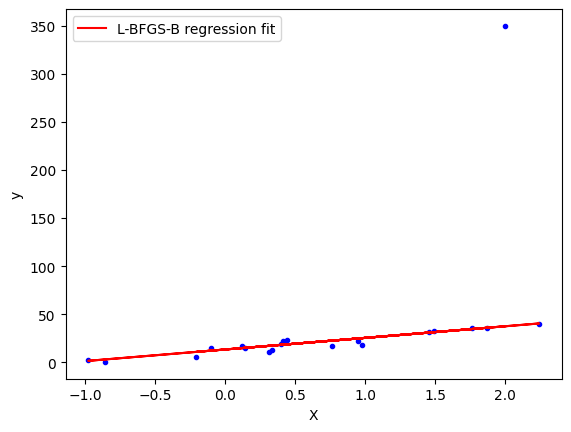

In [13]:
from scipy.optimize import fmin_l_bfgs_b

lbda = 0.01

def pobj_l2(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(w ** 2)

def huber_grad_l2(params, X, y, lbda, epsilon):
    w = params[1:]
    b = params[0]
    n_samples, n_features = X.shape
    grad_w = np.zeros(n_features)
    grad_b = 0
    for i in range(n_samples):
        grad_w += -X[i, :] * huber_grad(y[i] - np.dot(X[i, :], w) - b, epsilon=epsilon) + 2 * lbda * w
        grad_b += -huber_grad(y[i] - np.dot(X[i, :], w) - b, epsilon=epsilon)
    return np.concatenate([[grad_b/n_samples], grad_w/n_samples])

def huber_lbfgs_l2(X=X, y=y, lbda=lbda, epsilon=epsilon):
    n_samples, n_features = X.shape
    params, _, _ = fmin_l_bfgs_b(pobj_l2, x0=np.zeros(n_features + 1), fprime=huber_grad_l2, args=(X, y, lbda, epsilon))
    return params

t0 = time.perf_counter()
params = huber_lbfgs_l2(X, y, lbda, epsilon)
b_hat = params[0]
w_hat = params[1:]
print(f"Time for minimizing the huber loss with L2 regularization using the L-BFGS-B algorithm: {time.perf_counter() - t0:.3f}s")

x = X[:, 0]
ypred_lbfgs_l2 = X.dot(w_hat)+b_hat

plt.plot(x, y, 'b.')
plt.plot(x, ypred_lbfgs_l2, 'r-', label="L-BFGS-B regression fit")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

**Answer:** Using the `fmin_l_bfgs_b` function from `scipy.optimize`, we obtain a regression which is robust to the outlier in the dataset. The regression seems to fit perfectly the data as if the outlier was not present. Moreover, the computational time is 0.009s, which is faster than the one of the MAE QP solver. This is expected as the L-BFGS algorithm is more efficient than the QP solver for this problem. 

## Part 3: Huber Loss with L1 regularization

In this section we are interested in the $\ell_1$ regularized model.
To help you we give you the code of the objective function to minimize.

In [14]:
def pobj_l1(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(np.abs(w))

Now that we have the cost function, you are going to implement solvers based on:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)
- Proximal Coordinate Descent (PCD)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [15]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        if monit.x_min is None:
            ax1.set_ylabel("$f(x_k)$")
        else:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<div class="alert alert-success">
    <b>QUESTION 9a:</b>
    <ul>
    <li>
        Implement the proximal gradient descent (PGD) method.
    </li>
    </ul>
</div>

**Note:**  The parameter `step` is the size of the gradient step that you will need to propose by computing the Lipschitz constant of the data fitting term (Huber term without regularization term).

In [16]:
def pgd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.
    
    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        # TODO
        x = prox(x - step * grad(x, *grad_args), step, *prox_args)
        # END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

<div class="alert alert-success">
    <b>QUESTION 9b:</b>
    <ul>
    <li>
        Implement the L1 and L2 proximal operators. You will pay attention to the intercept.
    </li>
    <li>
        Using the monitor class and the plot_epochs function, display the convergence.
    </li>
    </ul>
</div>

In order to get a good value of `x_min` you will let your PGD solver run for 10000 iterations.

First you will need to implement the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

In [37]:
def prox_R2(params, reg=1.):
    w = params[1:]
    w = w / (1 + reg)
    return np.concatenate([[params[0]], w])


def prox_R1(params, reg=1.):
    w = params[1:]
    w = np.sign(w) * np.maximum(np.abs(w) - reg, 0)
    return np.concatenate([[params[0]], w])


def prox_l2(params, step, lbda):
    return prox_R2(params, reg=step * lbda)


def prox_l1(params, step, lbda):
    return prox_R1(params, reg=step * lbda)

Step: 0.4990622651965295


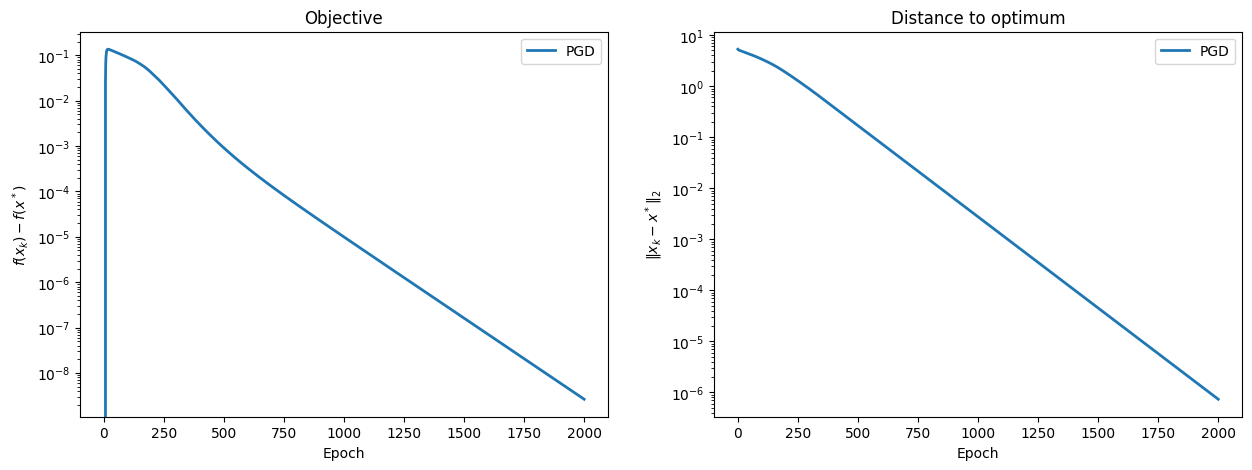

In [18]:
# Generate bigger data
X, y = make_regression(n_samples=500, n_features=100, random_state=0,
                       noise=4.0, bias=10.0)
n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 2000
# n_iter = 1000
lbda = 1.
epsilon = 1.

L = linalg.norm(X, ord=2) ** 2 / n_samples
step = 1. / L
print(f"Step: {step}")

def grad_huber_loss(params, X=X, y=y, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    n_samples, n_features = X.shape
    grad_w = np.zeros(n_features)
    grad_b = 0
    for i in range(n_samples):
        grad_w += -X[i, :] * huber_grad(y[i] - np.dot(X[i, :], w) - b, epsilon=epsilon)
        grad_b += -huber_grad(y[i] - np.dot(X[i, :], w) - b, epsilon=epsilon)
    return np.concatenate([[grad_b/n_samples], grad_w/n_samples])

x_min_l2, _ = pgd(x_init, grad_huber_loss, prox_l2, step, n_iter=10000,
               grad_args=(X, y, epsilon), prox_args=(lbda,))


# Run PGD
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min_l2, args=(X, y, lbda, epsilon))
monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

**Answer:** x_init == x*

Now for the $\ell_1$ regularization:

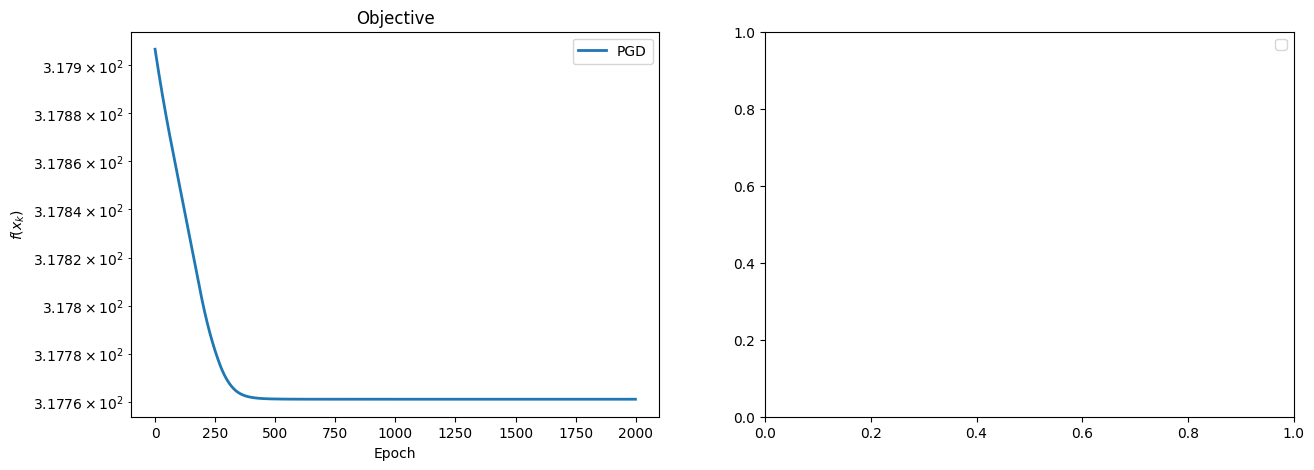

In [19]:
# x_min_l1, _ = pgd(x_init, grad_huber_loss, prox_l1, step, n_iter=10000, 
#                 grad_args=(X, y, epsilon), prox_args=(lbda,))

# Run PGD for L1
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=None, args=(X, y, lbda, epsilon))
monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 10:</b>
    <ul>
    <li>
        Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

In [20]:
def apgd(x_init, grad, prox, step, n_iter=100, store_every=1,
         grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        # TODO
        x_new = prox(y - step * grad(y, *grad_args), step, *prox_args)
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        y = x_new + (t - 1) / t_new * (x_new - x)
        x = x_new.copy()
        t = t_new.copy()
        # END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

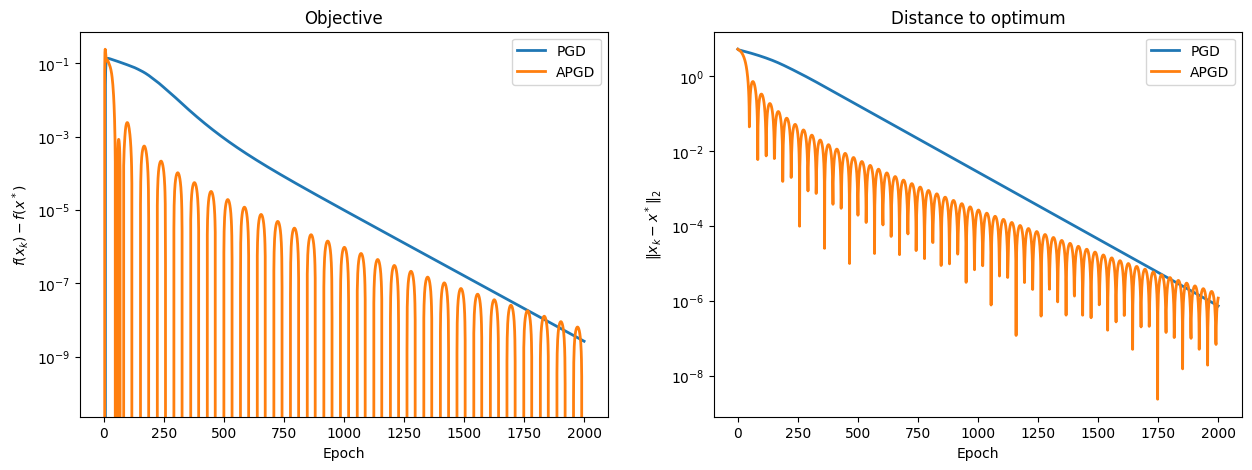

In [21]:
monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min_l2, args=(X, y, lbda, epsilon))
monitor_apgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                    grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

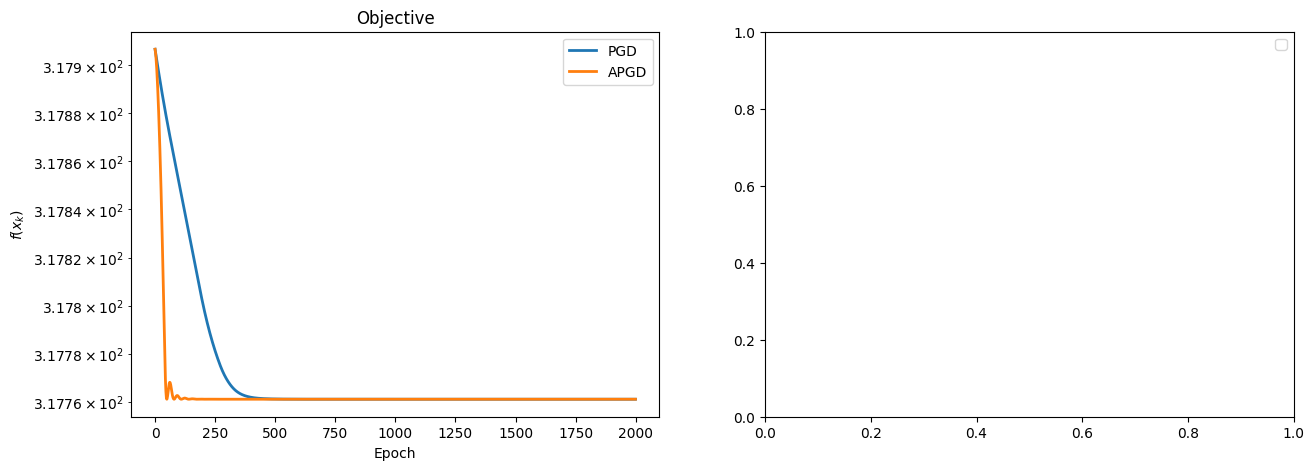

In [22]:
monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=None, args=(X, y, lbda, epsilon))
monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                    grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 11:</b>
    <ul>
    <li>
        Implement the proximal coordinate descent (PCD) and add this solver to the monitoring plots for L1 and L2 regularized models.
    </li>
    </ul>
</div>

**Note:** You are welcome to try to use numba to get reasonable performance but don't spend too much time if you get weird numba errors.

In [38]:
def pcd(x_init, grad, prox, step, n_iter=100, store_every=1, grad_args=(), prox_args=()):
    """
    Proximal Coordinate Descent (PCD) algorithm.

    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Initial parameters for the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        Step size for the gradient step.
    n_iter : int
        Number of iterations to perform.
    store_every : int
        Frequency to store the current parameter vector.
    grad_args : tuple
        Arguments to pass to the gradient function.
    prox_args : tuple
        Arguments to pass to the proximal function.

    Returns
    -------
    x : array, shape (n_parameters,)
        The optimized parameters.
    x_list : list
        List of parameter vectors at each stored iteration.
    """
    x = x_init.copy()
    n_params = len(x)
    x_list = []
    
    for iteration in range(n_iter):
        idx = np.random.randint(n_params)
        x[idx] = prox(x - step * grad(x, *grad_args), step, *prox_args)[idx]
        if iteration % store_every == 0:
            x_list.append(x.copy())
    return x, x_list


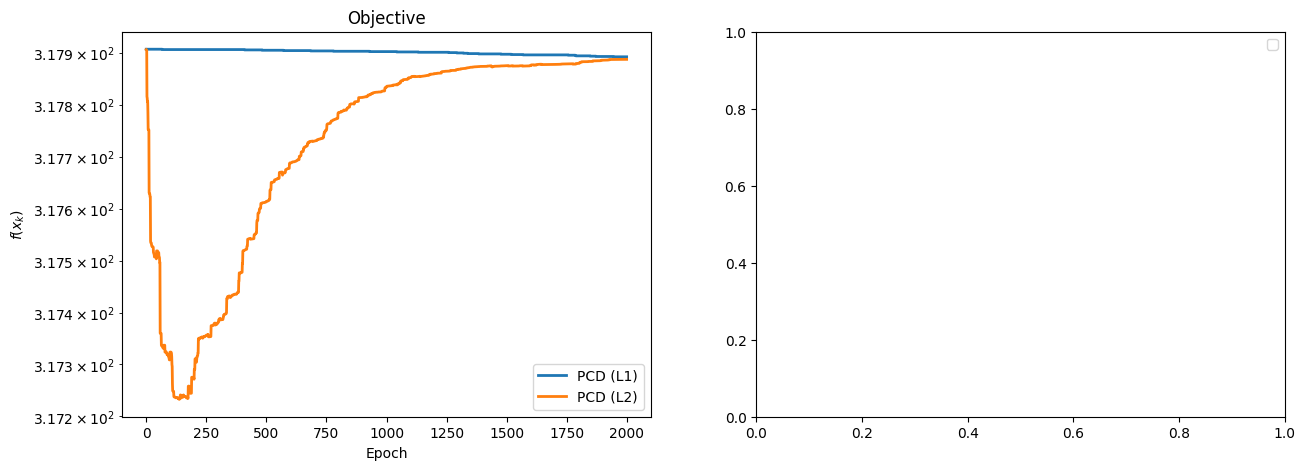

In [42]:
# Run PCD for L1-regularized model
monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=None, args=(X, y, lbda, epsilon))
monitor_pcd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter, grad_args=(X, y, epsilon), prox_args=(lbda,))

# Run PCD for L2-regularized model
monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min=None, args=(X, y, lbda, epsilon))
monitor_pcd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter, grad_args=(X, y, epsilon), prox_args=(lbda,))

# Add PCD to monitors
monitors = [monitor_pcd_l1, monitor_pcd_l2]
solvers = ["PCD (L1)", "PCD (L2)"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    <ul>
    <li>
        Compare the performance of the different solvers for different (simulated) problem sizes.
    </li>
    <li>
        What solver would you recommend for what problem and using what regularization?
    </li>
    </ul>
</div>

YOUR ANSWER HERE

## Part 4: Application

You will now apply your solver to an environment dataset. Given 2 features:

 - LNOxEm log of hourly sum of NOx emission of cars on this motorway in arbitrary units.
 - sqrtWS Square root of wind speed [m/s].

The objective is to predict:

 - log of hourly mean of NOx concentration in ambient air [ppb] next to a highly frequented motorway

**Disclaimer:** This dataset is not huge and regularization makes little sense with so little features but it serves as a simple illustration. Also, don't be surprised if Huber loss offers little to no benefit. Again it's just an illustration.

Let's first inspect the dataset:

In [53]:
import pandas as pd

df = pd.read_csv('NOxEmissions.csv', index_col=0).drop(['julday'], axis=1)
df.head()

,LNOx,LNOxEm,sqrtWS
193,4.457250,5.536489,0.856446
194,4.151827,5.513000,1.016612
195,3.834061,4.886994,1.095445
196,4.172848,5.138912,1.354068
197,4.322807,5.666518,1.204159


Now let's extract `X` and `y`

In [54]:
X = df.loc[:, ['LNOxEm', 'sqrtWS']].values
y = df['LNOx']
X.shape, y.shape

((8088, 2), (8088,))

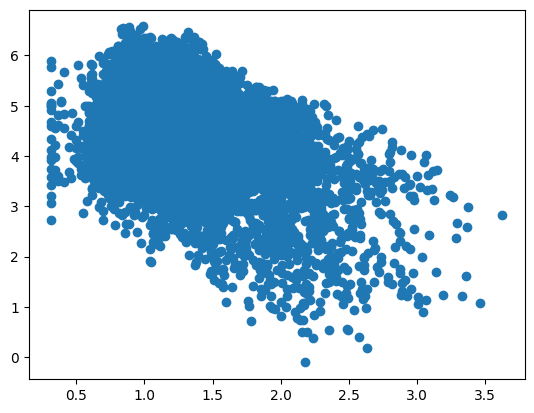

In [55]:
plt.scatter(X[:, 1], y);

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

<div class="alert alert-success">
    <b>QUESTION 13:</b>
    <ul>
    <li>
        Implement the `fit` method from the estimator in the next cell
    </li>
    </ul>
</div>

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin


class HuberRegressor(BaseEstimator, RegressorMixin):
    """scikit-learn estimator for regression with a Huber loss
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'pcd'
        The type of algorithm to use.
        
    Attributes
    ----------
    coef_ : ndarray, (n_features,)
        The weitghs w.
    intercept_ : float
        The intercept or bias term b.
    """
    def __init__(self, lbda=1., penalty='l2', epsilon=1.,
                 max_iter=2000, solver='pgd'):
        self.lbda = lbda
        self.penalty = penalty
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.solver = solver
        assert epsilon > 0.
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'pcd'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
        """
        X = np.asarray(X)  # Convert X to NumPy array
        y = np.asarray(y)  # Convert y to NumPy array
        n_samples, n_features = X.shape
        
        # Set initial values of parameters to optimize
        x_init = np.zeros(n_features + 1)
        x_init[0] = np.mean(y)
        L = linalg.norm(X.T @ X, ord=2) ** 2 / self.epsilon
        step = 1. / L

        if self.penalty == 'l2':
            prox = prox_l2
        else:
            prox = prox_l1

        if self.solver == 'pgd':
            x, _ = pgd(x_init, grad_huber_loss, prox, step, n_iter=self.max_iter, grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))
        elif self.solver == 'apgd':
            x, _ = apgd(x_init, grad_huber_loss, prox, step, n_iter=self.max_iter, grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))
        else:
            x, _ = pcd(x_init, grad_huber_loss, prox, step, n_iter=self.max_iter, grad_args=(X, y, self.epsilon), prox_args=(self.lbda,))

        self.params_ = x
        self.coef_ = x[1:]
        self.intercept_ = x[0]
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.dot(X, self.coef_) + self.intercept_

    
    def score(self, X, y):
        """Score using negative mean absolute error
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
            
        Returns
        -------
        score : float
            The negative mean absolute error.
            Negative to keep the semantic that higher is better.
        """
        return -np.mean(np.abs(y - self.predict(X)))


for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=1., penalty='l2', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L2: %s   \t-   MAE : %.5f' % (solver, -clf.score(X, y)))

for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=1., penalty='l1', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L1: %s   \t-   MAE : %.5f' % (solver, -clf.score(X, y)))

Solver with L2: pgd   	-   MAE : 0.71925
Solver with L2: apgd   	-   MAE : 0.71935
Solver with L2: pcd   	-   MAE : 0.71925
Solver with L1: pgd   	-   MAE : 0.71925


KeyboardInterrupt: 

<div class="alert alert-success">
    <b>QUESTION 14:</b>
    <ul>
        <li>
            Compare the cross-validation performance of your model (using `cross_val_score`) with a Ridge or Lasso regression models using as scoring metric the "mean absolute error" (MAE).
        </li>
        <li>
            You will check that the Huber model matches Ridge when epsilon is large. Pay attention to how the loss is scaled in scikit-learn for Ridge (no normalization by 1/n_samples).
        </li>
        <li>
            You will comment on the running time of your solver to reach their optimal prediction performance.
        </li>
    </ul>
</div>

To score your model with MAE using cross_val_score you need to pass as parameter `scoring='neg_mean_absolute_error'`.

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score

# TODO

# END TODO